# Исследование данных сервиса аренды самокатов
Изучаем данные сервиса аренды самокатов GoFast: имеются данные о пользователях из нескольких городов, их поездках и подписках.
Проанализируем данные и проверим некоторые статистические гипотезы, которые могут помочь бизнесу вырасти.

#### Шаг 1. Загрузка данных

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:
# загрузим таблицу с данными о пользователях
users = pd.read_csv('/datasets/users_go.csv')


In [3]:
# посмотрим на данные
display(users.head())
display(users.info())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

В таблице users содержится 1565 записей с данными о пользователях, **пропусков в данных нет**

In [4]:
# загрузим таблицу с данными о поездках
rides = pd.read_csv('/datasets/rides_go.csv')

In [5]:
# посмотрим на данные
display(rides.head())
display(rides.info())

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

В таблице rides содержится 18068 записей с данными о поездках, **пропусков в данных нет**

In [6]:
# загрузим таблицу с данными о подписках
subs = pd.read_csv('/datasets/subscriptions_go.csv')


In [7]:
# посмотрим на данные
display(subs.head())
display(subs.info())

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

В таблице subs содержится 2 записи с данными о стоимости сервиса с подпиской и без, **пропусков в данных нет**

#### Шаг 2. Предобработка данных

##### Приведем столбец date к типу даты pandas.

In [8]:
rides['date'] = pd.to_datetime(rides['date'] , format = '%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


#####  Создайте новый столбец с номером месяца на основе столбца date.

In [9]:
rides['month'] = rides['date'].dt.month
rides.head(1)

,user_id,distance,duration,date,month
0,1,4409.91914,25.599769,2021-01-01,1


In [10]:
print("Период, за который представлены данные о поездках: с", rides.date.min(), "по", rides.date.max())

Период, за который представлены данные о поездках: с 2021-01-01 00:00:00 по 2021-12-30 00:00:00


#####  Проверим наличие пропущенных значений и дубликатов в датафреймах. 

В Шаге 1 при изучении данных о датафреймах убедились, что **пропусков в данных нет**.

Проверим, ести ли в таблицах users и rides дубликаты. Если есть, удалим их. **В таблице subs всего 2 записи, дубликатов нет**

In [11]:
print("Количество дубликтов в таблице users:", users.duplicated().sum()) #проверяем, есть ли дубликаты
users.drop_duplicates(inplace=True) #удаляем дубликаты

Количество дубликтов в таблице users: 31


In [12]:
print("Количество дубликтов в таблице rides:", rides.duplicated().sum())

Количество дубликтов в таблице rides: 0


Датафреймы с данными о пользователях и поездках не содержали пропусков. В данных о пользователях были дублирующие строки - 31 строка, дубликаты были удалены.

##### добавим в таблицу rides столбец с округленным в большую сторону временем поездки
*Это пригодится при расчете стоимости поездки*

In [13]:
rides['duration_ceil'] = np.ceil(rides['duration'])
rides['duration_ceil'].head()

0    26.0
1    16.0
2     7.0
3    19.0
4    27.0
Name: duration_ceil, dtype: float64

#### Шаг 3. Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках:

##### частота встречаемости городов;

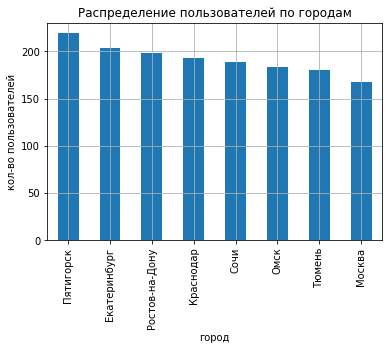

In [14]:
(
    users['city']
    .value_counts()
    .plot(kind = 'bar', grid = True, figsize = (6,4), title = 'Распределение пользователей по городам',\
          xlabel = 'город', ylabel = 'кол-во пользователей')
);


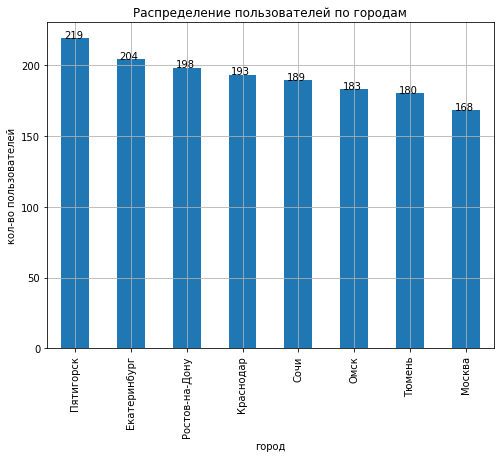

In [43]:
import matplotlib.pyplot as plt

# Построение распределения пользователей по городам
users['city'].value_counts().plot(kind='bar', grid=True, figsize=(8, 6), title='Распределение пользователей по городам', xlabel='город', ylabel='кол-во пользователей')

# Добавление значений над столбцами
for index, value in enumerate(users['city'].value_counts()):
    plt.text(index - 0.2, value + 0.1, str(value))  # Размещение значения чуть выше столбца

plt.show()


В таблице users содержатся данные о почти 1600 пользователях из 8 городов России. Больше всего в таблице пользователей из Пятигорска (219 человек), меньше всего - из Москвы (168 человек).

##### возраст пользователей

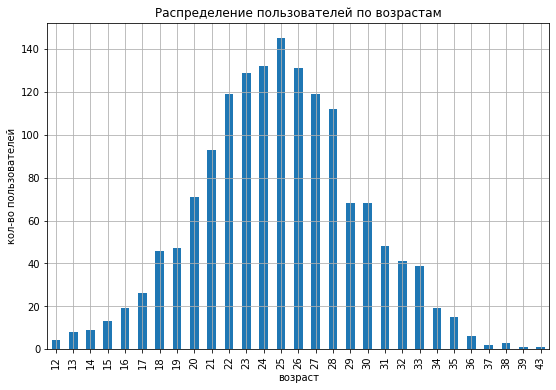

In [15]:
(
    users['age']
    .value_counts()
    .sort_index()
    .plot(kind = 'bar', grid = True, figsize = (9,6), title = 'Распределение пользователей по возрастам',\
          xlabel = 'возраст', ylabel = 'кол-во пользователей')
);

In [16]:
users['age'].describe(percentiles = [.05, .25, .5, .75, .95])

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
5%         17.000000
25%        22.000000
50%        25.000000
75%        28.000000
95%        33.000000
max        43.000000
Name: age, dtype: float64

- В представленной таблице есть данные о больше чем 1500 пользователях сервиса. 
- Пользователи в таблице - это люди в возрасте от 12 до 43 лет.
- 90% пользователей - это люди в возрасте от 17 до 33 лет.
- Больше всего пользователей в возрасте 25 лет - больше 140 человек.

##### соотношение пользователей с подпиской и без подписки

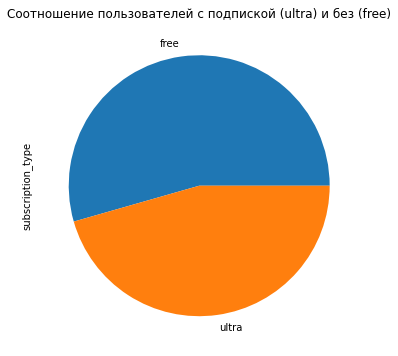

In [17]:
(
    users['subscription_type']
    .value_counts()
    .plot(kind = 'pie', grid = True, figsize = (9,6),title = 'Соотношение пользователей с подпиской (ultra) и без (free)')
);

Пользователей с подпиской и без примерно равное количество, чуть больше пользователей не имеют подписки.

##### расстояние, которое пользователь преодолел за одну поездку

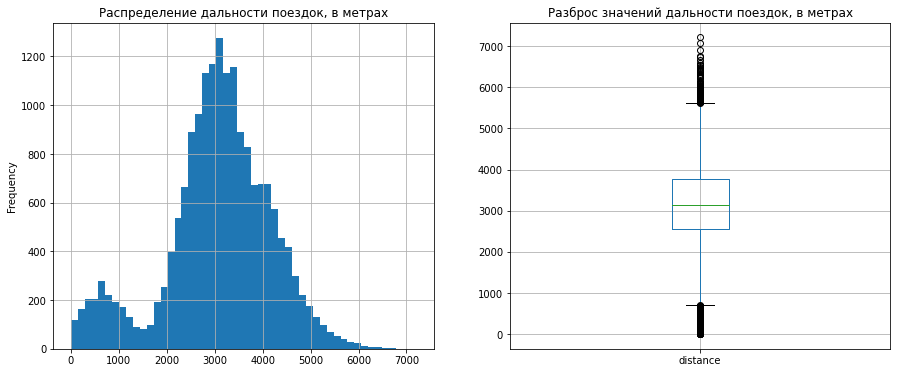

In [18]:
fig, ax = plt.subplots(1,2 , figsize = (15,6))

rides.distance.plot(kind = 'hist', bins = 50, grid = True, title = 'Распределение дальности поездок, в метрах', ax = ax[0])
rides.boxplot(column = 'distance', ax = ax[1])
ax[1].set_title('Разброс значений дальности поездок, в метрах')
plt.show()

In [19]:
rides.distance.describe(percentiles = [.05, .25, .5, .75, .95])

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
5%         689.007279
25%       2543.226360
50%       3133.609994
75%       3776.222735
95%       4740.088596
max       7211.007745
Name: distance, dtype: float64

In [20]:
display(rides.query('distance<1500')['distance'].median())
display(rides.query('distance>=1500')['distance'].median())

687.5367134052547

3239.972305386772

In [21]:
display(rides.query('distance == @rides.distance.min()'))
display(rides.query('distance == @rides.distance.max()'))

,user_id,distance,duration,date,month,duration_ceil
11555,1069,0.855683,10.001902,2021-01-31,1,11.0


,user_id,distance,duration,date,month,duration_ceil
16309,1411,7211.007745,0.5,2021-04-15,4,1.0


- Распределение расстояния одной поездки имеет 2 пика: первый около 700 метров, второй - около 3200 метров. Видимо, первый пик соответствует поездкам, когда пользователю надо быстро добраться до места, таких поездок не очень много - всего порядка 5% всей выборки. Второй пик может соответствовать поездкам пользователя, например, от дома до работы, или же прогулкам на самокате. Таких поездок - большинство.
- Минимальное расстояние одной поездки - меньше метра (вероятно, пользователь активировал поездку в приложении, но передумал ехать)
- Максиальное расстояние одной поездки - свыше 7 км. Однако в записи этой поездки есть какой-то технический сбой, т.к. указана продолжительность поездки - 0.5 минут (рассмотрим продолжительности поездок ниже)
- ***90% поездок на самокатах совершаются на расстояния от 700 до 4700 метров.***

##### продолжительность поездок

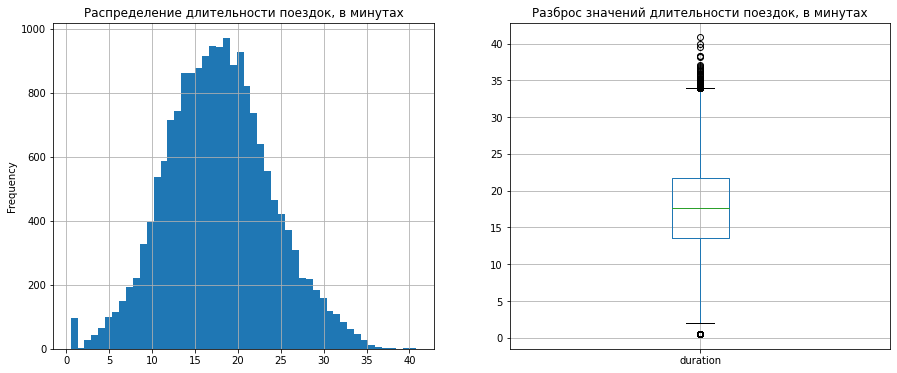

In [22]:
fig, ax = plt.subplots(1,2 , figsize = (15,6))

rides.duration.plot(kind = 'hist', bins = 50, grid = True, title = 'Распределение длительности поездок, в минутах', ax = ax[0])

rides.boxplot(column = 'duration', ax = ax[1])
ax[1].set_title('Разброс значений длительности поездок, в минутах')
plt.show()

In [23]:
rides.duration.describe(percentiles = [.05, .25, .5, .75, .95])

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
5%           8.244528
25%         13.597563
50%         17.678395
75%         21.724800
95%         28.428730
max         40.823963
Name: duration, dtype: float64

- Распределение продолжительности одной поездки имеет 2 пика: первый  - 0.5 минут, второй - около 17 минут. *Дальше посмотрим на поездки с указанной продолжительностью полминуты подробнее.* 
- Максиальная длительность одной поездки - 40 минут. 
- ***90% поездок на самокатах имеют продолжительность от 8 до 28 минут.***

In [24]:
rides.query('duration == 0.5')

,user_id,distance,duration,date,month,duration_ceil
6531,701,4196.445201,0.5,2021-08-31,8,1.0
6570,704,4830.824371,0.5,2021-10-14,10,1.0
6680,712,4684.004397,0.5,2021-03-04,3,1.0
6695,713,5215.642710,0.5,2021-02-25,2,1.0
6768,718,5197.436649,0.5,2021-02-11,2,1.0
...,...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1,1.0
17242,1477,6724.932981,0.5,2021-01-12,1,1.0
17314,1483,4445.481070,0.5,2021-03-06,3,1.0
17505,1496,5722.551787,0.5,2021-02-14,2,1.0


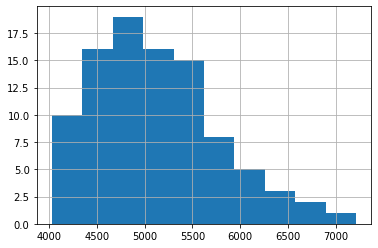

In [25]:
rides.query('duration == 0.5')['distance'].hist();

Видно, что записи, у которых duration = 0.5, - это поездки разных пользователей в разные дни, разные месяцы. Всего таких записей - 95 штук. 

При этом, расстояния этих поездок - от 4 до 7 км, что не имеет никакого физического смысла. Можно предположить, что такие записи соответствуют либо каким-то техническим сбоям в оценке времени, либо это заполнение пропущенных значений. 

#### Шаг 4. Объединение данных

##### Объединим данные о пользователях, поездках и подписках в один датафрейм. 

In [27]:
data = rides.merge(users, how = 'left', left_on='user_id', right_on='user_id')
data = data.merge(subs, how = 'left', left_on='subscription_type', right_on='subscription_type')
data.head()

,user_id,distance,duration,date,month,duration_ceil,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,26.0,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,16.0,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,7.0,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,19.0,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,27.0,Кира,22,Тюмень,ultra,6,0,199


In [28]:
print(f'Проверим, не потеряли ли данные при объединении датасетов')
print(f'Кол-во записей о поездках до объединения датасетов: {rides.shape[0]}')
print(f'Кол-во записей о поездках после объединения датасетов: {data.shape[0]}')

if (rides.shape[0] == data.shape[0]):
    print('Все ок, данные не потерялись')
else:
    print('Часть данных потеряна')

Проверим, не потеряли ли данные при объединении датасетов
Кол-во записей о поездках до объединения датасетов: 18068
Кол-во записей о поездках после объединения датасетов: 18068
Все ок, данные не потерялись


#####  Создаем ещё два датафрейма из датафрейма, созданного на этапе 4.1:
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.


In [29]:
data_wo_subs = data[data.subscription_type == 'free']
data_w_subs = data[data.subscription_type == 'ultra']

In [30]:
display (data.head())
display(data_wo_subs.head(2))
display(data_w_subs.head(2))

,user_id,distance,duration,date,month,duration_ceil,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,26.0,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,16.0,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,7.0,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,19.0,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,27.0,Кира,22,Тюмень,ultra,6,0,199


,user_id,distance,duration,date,month,duration_ceil,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,15.0,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,17.0,Айдар,22,Омск,free,8,50,0


,user_id,distance,duration,date,month,duration_ceil,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,26.0,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,16.0,Кира,22,Тюмень,ultra,6,0,199


#####  Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

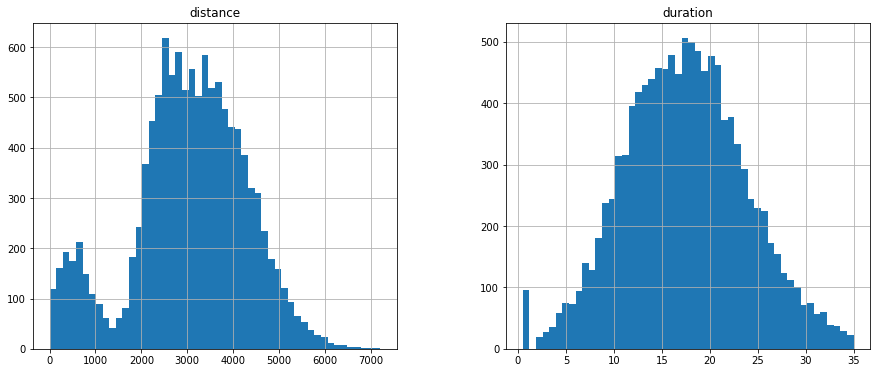

In [31]:
#гистограммы расстояния и продолжительности поездок пользователей без подписки
fig, ax = plt.subplots(1,2, figsize = (15,6))
data_wo_subs.hist(column = 'distance', bins = 50, ax = ax[0])
data_wo_subs.hist(column = 'duration', bins = 50, ax = ax[1])

plt.show()

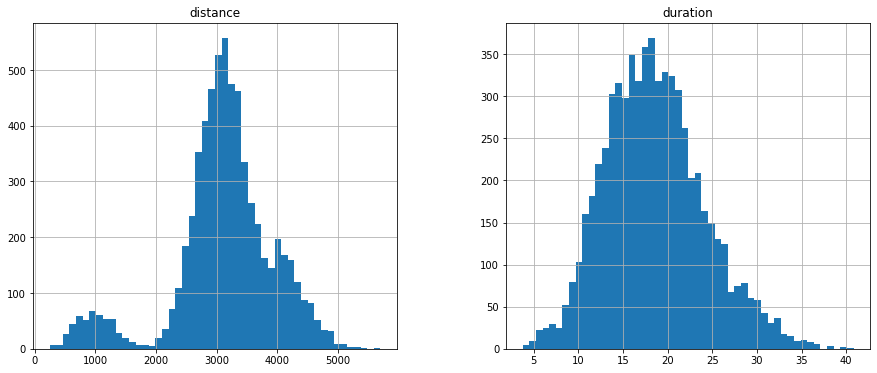

In [32]:
#гистограммы расстояния и продолжительности поездок пользователей с подпиской
fig, ax = plt.subplots(1,2, figsize = (15,6))
data_w_subs.hist(column = 'distance', bins = 50, ax = ax[0])
data_w_subs.hist(column = 'duration', bins = 50, ax = ax[1])

plt.show()

In [33]:
print("Описательная статистика для поездок пользователей без подписки")
display(data_wo_subs[['distance', 'duration']].describe(percentiles = [.05, .25, .5, .75, .95]))
print("Описательная статистика для поездок пользователей с подписками")
display(data_w_subs[['distance', 'duration']].describe(percentiles = [.05, .25, .5, .75, .95]))

Описательная статистика для поездок пользователей без подписки


,distance,duration
count,11568.000000,11568.000000
mean,3045.495282,17.390909
std,1246.173806,6.326803
min,0.855683,0.500000
5%,524.185294,7.244460
25%,2366.562689,12.958437
50%,3114.648465,17.326890
75%,3905.697894,21.594071
95%,4934.728012,28.246500
max,7211.007745,34.948498


Описательная статистика для поездок пользователей с подписками


,distance,duration
count,6500.000000,6500.000000
mean,3115.445388,18.541985
std,836.895330,5.572048
min,244.210438,3.760353
5%,1119.722350,10.264039
25%,2785.444017,14.524654
50%,3148.637229,18.178153
75%,3560.574425,21.884129
95%,4382.285625,28.720878
max,5699.769662,40.823963


- Всего поездок у пользователей без подписок почти в 2 раза больше, чем у пользователей с подписками (11.4 тыс протиы 6.5 тыс поездок, соответственно). При этом, как выяснили выше, всего пользоватлей без подписки незначительно больше, чем пользователей с подпиской, значит пользователь без подписки совершают поездки чаще.
- Распределения дальности и продолжительности поездок для обеих категорий пользователей выглядят примерно одинаково
- Распределение дальности поездок - бимодальное, с модами 600/1000 и примерно 3000 метров у пользователей без и с подпиской, соответсвтенно. Разброс значений для пользователей без подписки больше, стандартное отклонение - 1200 м, а для выборки с пользователями бещ подписки - 830 метров.
- Распределения продолжительности поездок схожи для двух групп пользователей со средним временем поездки около 18 минут и стандартным отклонением около 6 минут.

#### Шаг 5. Подсчёт выручки

##### Создаем датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: 
найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.


In [34]:
data_agg_w_subs = (
    data_w_subs
    .groupby(['user_id', 'month'])
    .agg(distanse_cum = ('distance', 'sum'), count = ('distance', 'count'), duration_cum = ('duration_ceil', 'sum'))
    .sort_values(by =['user_id', 'month'])
    .reset_index()
)

display(data_agg_w_subs.head())


data_agg_wo_subs = (
    data_wo_subs
    .groupby(['user_id', 'month'])
    .agg(distanse_cum = ('distance', 'sum'), count = ('distance', 'count'), duration_cum = ('duration_ceil', 'sum'))
    .sort_values(by =['user_id', 'month'])
    .reset_index()
)

display(data_agg_wo_subs.head())

,user_id,month,distanse_cum,count,duration_cum
0,1,1,7027.511294,2,42.0
1,1,4,754.159807,1,7.0
2,1,8,6723.470560,2,46.0
3,1,10,5809.911100,2,32.0
4,1,11,7003.499363,3,56.0


,user_id,month,distanse_cum,count,duration_cum
0,700,1,2515.690719,1,15.0
1,700,2,13446.659764,5,89.0
2,700,3,3798.334905,1,19.0
3,700,4,2984.551206,1,16.0
4,700,6,5927.650988,2,29.0


In [35]:
# проверка на пропуски в сводной таблице
display(data_agg_w_subs.isna().sum())
display(data_agg_wo_subs.isna().sum())

user_id         0
month           0
distanse_cum    0
count           0
duration_cum    0
dtype: int64

user_id         0
month           0
distanse_cum    0
count           0
duration_cum    0
dtype: int64

#####  В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. 

***Помесячная выручка считается по формуле:***

*стоимость старта поездки × количество поездок + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах + стоимость подписки.*

***без подписки***
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;

***с подпиской Ultra***
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

In [36]:
start_price = 0
price_per_min = 6
subs_price = 199

data_agg_w_subs['month_revenue'] = start_price*data_agg_w_subs['count'] + \
                                    price_per_min*data_agg_w_subs['duration_cum'] +\
                                    subs_price
data_agg_w_subs.head()

,user_id,month,distanse_cum,count,duration_cum,month_revenue
0,1,1,7027.511294,2,42.0,451.0
1,1,4,754.159807,1,7.0,241.0
2,1,8,6723.470560,2,46.0,475.0
3,1,10,5809.911100,2,32.0,391.0
4,1,11,7003.499363,3,56.0,535.0


In [37]:
start_price = 50
price_per_min = 8
subs_price = 0

data_agg_wo_subs['month_revenue'] = start_price*data_agg_wo_subs['count'] + \
                                    price_per_min*np.ceil(data_agg_wo_subs['duration_cum']) +\
                                    subs_price
data_agg_wo_subs.head()

,user_id,month,distanse_cum,count,duration_cum,month_revenue
0,700,1,2515.690719,1,15.0,170.0
1,700,2,13446.659764,5,89.0,962.0
2,700,3,3798.334905,1,19.0,202.0
3,700,4,2984.551206,1,16.0,178.0
4,700,6,5927.650988,2,29.0,332.0


In [38]:
data_agg_w_subs

,user_id,month,distanse_cum,count,duration_cum,month_revenue
0,1,1,7027.511294,2,42.0,451.0
1,1,4,754.159807,1,7.0,241.0
2,1,8,6723.470560,2,46.0,475.0
3,1,10,5809.911100,2,32.0,391.0
4,1,11,7003.499363,3,56.0,535.0
...,...,...,...,...,...,...
4528,699,6,4072.797406,1,17.0,301.0
4529,699,8,7018.324143,2,45.0,469.0
4530,699,9,6364.861911,2,31.0,385.0
4531,699,10,4707.845501,1,16.0,295.0


#### Шаг 6. Проверка гипотез

##### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? 
Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.


Для проверки гипотезы будем использовать правосторонний t-тест для незавсимых выборок с уровнем значимости 5%

**H0 гипотеза**: средние значения продолжительности поездок у пользователей с подпиской и без равны

**H1 гипотеза**: у пользователей с подпиской продолжительность поездок выше

In [39]:
# для проверки гипотезы используем правосторонний t-тест для незавсимых выборок с уровнем значимости 5%
alpha = 0.05

print('Среднее время поездки у пользователей с подпиской', data_w_subs['duration'].mean())
print('Среднее время поездки у пользователей без подписки', data_wo_subs['duration'].mean())

results = st.ttest_ind(data_w_subs['duration'], data_wo_subs['duration'], alternative = 'greater')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу (о равенстве средних)')
else:
    print('Не можем отвергнуть нулевую гипотезу')

print('p-value:', results.pvalue)

Среднее время поездки у пользователей с подпиской 18.54198516280583
Среднее время поездки у пользователей без подписки 17.39090929866399
Отвергаем нулевую гипотезу (о равенстве средних)
p-value: 1.2804098316645618e-34


t-тест показал, что мы не можем отвергнуть нулевую гипотезу о равенстве двух средних для продолжительности поездок у пользователей с подписками и без, а значит ***не можем подтвердить предположение о том, что пользователи с подпиской в среднем тратят больше времени на поездки.***

#####  Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 
*Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.*

Для проверки гипотезы будем использовать одновыборочный правосторонний t-тест с уровнем значимости 5%

**H0 гипотеза**: среднее значение дальности поездок у пользователей с подпиской равно 3130 метров

**H1 гипотеза**: расстояние поездок у пользователей с подпиской превышает 3130 метров

In [40]:
# для проверки гипотезы используем одновыборочный правосторонний t-тест с уровнем значимости 5%
value = 3130
alpha = 0.05

sample = data_w_subs['distance']

print("Среднее расстояние:", sample.mean())

results = st.ttest_1samp(sample, value, alternative = 'greater')

print("p-value:", results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу (о равенстве истинного среднего значению 3130 метров)')
else:
    print('Не можем отвергнуть нулевую гипотезу')



Среднее расстояние: 3115.4453880370247
p-value: 0.9195368847849785
Не можем отвергнуть нулевую гипотезу


Не можем отвергнуть нулевую гипотезу (о равенстве истинного среднего значению 3130 метров) 

##### Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Для проверки гипотезы будем использовать правосторонний t-тест для двух завсимых выборок с уровнем значимости 5%

**H0 гипотеза**: средние значения выручки за месяц от пользователей с подпиской и без равны

**H1 гипотеза**:  помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

In [41]:
# для проверки гипотезы используем правосторонний t-тест для двух завсимых выборок с уровнем значимости 5%
alpha = .05

print('Средняя выручка за месяц от пользователей с подпиской', data_agg_w_subs['month_revenue'].mean())
print('Средняя выручка за месяц от пользователей без подписки', data_agg_wo_subs['month_revenue'].mean())

results = st.ttest_ind(data_agg_w_subs['month_revenue'], data_agg_wo_subs['month_revenue'], alternative = 'greater')

print('p-value', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу (о равенстве истинного средних значений двух выборок)')
else:
    print('Не можем отвергнуть нулевую гипотезу')


Средняя выручка за месяц от пользователей с подпиской 362.7921906022502
Средняя выручка за месяц от пользователей без подписки 328.6413651073845
p-value 1.8850394384715216e-31
Отвергаем нулевую гипотезу (о равенстве истинного средних значений двух выборок)


Отвергаем нулевую гипотезу (о равенстве истинного средних значений двух выборок) в пользу альтернативной гипотезы: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

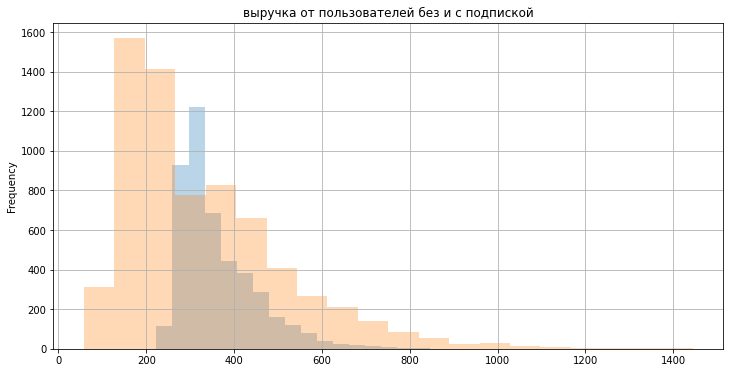

In [42]:
ax = data_agg_w_subs['month_revenue'].plot(kind = 'hist', bins = 20, grid = True, figsize = (12,6), alpha = .3)
data_agg_wo_subs['month_revenue'].plot(kind = 'hist', bins = 20, grid = True, ax= ax,  alpha = .3, title = "выручка от пользователей без и c подпиской");


*На гистограмме с помесячной выручкой от пользователей обеих групп также видно, что пользователи с подпиской (на гистограмме голубым) приносят компании гораздо в среднем больше дохода, чем пользователи без подписки (на графике - оранжевым).*

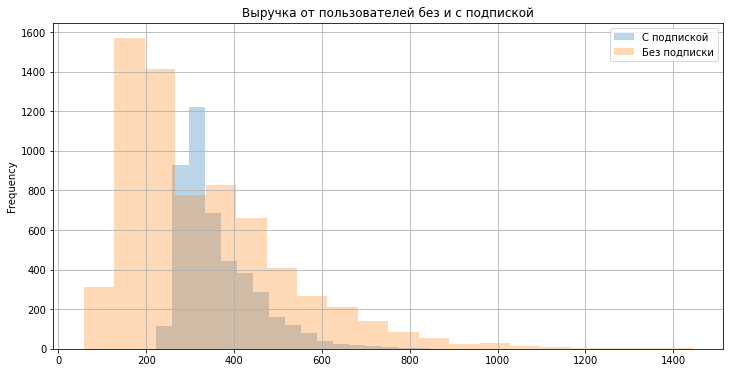

In [45]:
import matplotlib.pyplot as plt

# Построение гистограммы для выручки
ax = data_agg_w_subs['month_revenue'].plot(kind='hist', bins=20, grid=True, figsize=(12, 6), alpha=0.3)
data_agg_wo_subs['month_revenue'].plot(kind='hist', bins=20, grid=True, ax=ax, alpha=0.3)

# Добавление легенды
ax.legend(['С подпиской', 'Без подписки'])

# Добавление заголовка
plt.title('Выручка от пользователей без и с подпиской')

plt.show()


##### Представим такую ситуацию: 
*техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?*

Для проверки этой гипотезы понадобился бы двухвыборочный t-тест для зависимых выборок  проверяет одностороннюю гипотезу о том, что до изменения (первая выборка) среднее значение переменной в генеральной совокупности было больше, чем после изменения (вторая выборка) - **st.ttest_rel(sample1, sample2, alternative = 'greater')**

#### Общие выводы

В рамках исследования данных сервиса аренды самокатов изучили данные о пользователях и совершенных этими пользователями поездках. Данные были очищены от дубликатов (удалена 31 запись из датасета с данными пользователей) и выбросов (95 записей в данных с поездками с неправдоподобно маленькой продолжительностью поездок). По объединенным и агрегированным данным были проверены несколько статистических гипотез, которые могут помочь бизнесу, и сделаны следующие выводы: 

- ***тратят ли пользователи с подпиской больше времени на поездки*** - не смогли подтвердить данное предположение на данных

*Поскольку стоимость поездки напрямую зависит от продолжительности поездки, будет экономически выгодно мотивировать пользователей пользоваться самокатами дольше - совершать более длительные поездки*

- ***расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров*** - подтвердили предположение на данных

*3130 метров - оптмальное расстояние с т.з. износа самоката, необходимо следить, чтобы и в будущем это условие выполнялось*
- ***помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки*** - предположение подтверждается на данных

*Значит, необходимо мотивировать пользователей покупать подписку*